## Multi Turn

In [1]:
import random
from typing import Annotated, Literal

from langchain_core.tools import tool
from langchain_core.tools.base import InjectedToolCallId
from langgraph.prebuilt import InjectedState

from langchain_ollama import ChatOllama
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt import create_react_agent, InjectedState
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver

from pydantic import BaseModel, Field

In [2]:
@tool
def get_travel_recommendations():
    """Get recommendation for travel destinations"""
    return random.choice(["aruba", "turks and caicos"])


@tool
def get_hotel_recommendations(location: Literal["aruba", "turks and caicos"]):
    """Get hotel recommendations for a given destination."""
    return {
        "aruba": [
            "The Ritz-Carlton, Aruba (Palm Beach)"
            "Bucuti & Tara Beach Resort (Eagle Beach)"
        ],
        "turks and caicos": ["Grace Bay Club", "COMO Parrot Cay"],
    }[location]


def make_handoff_tool(*, agent_name: str):
    """Create a tool that can return handoff via a Command"""
    tool_name = f"transfer_to_{agent_name}"

    @tool(tool_name)
    def handoff_to_agent(
        state: Annotated[dict, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Ask another agent for help."""
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": tool_name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            # navigate to another agent node in the PARENT graph
            goto=agent_name,
            graph=Command.PARENT,
            # This is the state update that the agent `agent_name` will see when it is invoked.
            # We're passing agent's FULL internal message history AND adding a tool message to make sure
            # the resulting chat history is valid.
            update={"messages": state["messages"] + [tool_message]},
        )

    return handoff_to_agent

In [3]:
model = ChatOllama(model="qwen2.5:14b", temperature=0.0)

In [4]:
# Define travel advisor tools and ReAct agent
travel_advisor_tools = [
    get_travel_recommendations,
    make_handoff_tool(agent_name="hotel_advisor"),
]
travel_advisor = create_react_agent(
    model,
    travel_advisor_tools,
    prompt=(
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help. "
        "You MUST include human-readable response before transferring to another agent."
    ),
)


def call_travel_advisor(
    state: MessagesState,
) -> Command[Literal["hotel_advisor", "human"]]:
    # You can also add additional logic like changing the input to the agent / output from the agent, etc.
    # NOTE: we're invoking the ReAct agent with the full history of messages in the state
    response = travel_advisor.invoke(state)
    return Command(update=response, goto="human")


# Define hotel advisor tools and ReAct agent
hotel_advisor_tools = [
    get_hotel_recommendations,
    make_handoff_tool(agent_name="travel_advisor"),
]
hotel_advisor = create_react_agent(
    model,
    hotel_advisor_tools,
    prompt=(
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
        "You MUST include human-readable response before transferring to another agent."
    ),
)


def call_hotel_advisor(
    state: MessagesState,
) -> Command[Literal["travel_advisor", "human"]]:
    response = hotel_advisor.invoke(state)
    return Command(update=response, goto="human")



In [5]:
def human_node(
    state: MessagesState, config
) -> Command[Literal["hotel_advisor", "travel_advisor", "human"]]:
    """A node for collecting user input."""

    user_input = interrupt(value="Ready for user input.")

    # identify the last active agent
    # (the last active node before returning to human)
    langgraph_triggers = config["metadata"]["langgraph_triggers"]
    if len(langgraph_triggers) != 1:
        raise AssertionError("Expected exactly 1 trigger in human node")

    active_agent = langgraph_triggers[0].split(":")[1]

    return Command(
        update={
            "messages": [
                {
                    "role": "human",
                    "content": user_input,
                }
            ]
        },
        goto=active_agent,
    )

In [6]:
builder = StateGraph(MessagesState)
builder.add_node("travel_advisor", call_travel_advisor)
builder.add_node("hotel_advisor", call_hotel_advisor)

# This adds a node to collect human input, which will route
# back to the active agent.
builder.add_node("human", human_node)

# We'll always start with a general travel advisor.
builder.add_edge(START, "travel_advisor")


checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

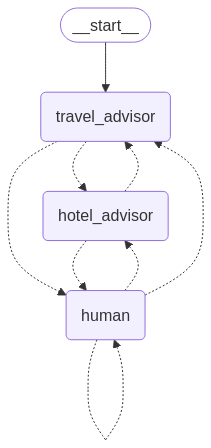

In [7]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4()), "user_id": "1"}}

In [9]:
def print_stream(stream):
    for ns, update in stream:
        print(f"Namespace '{ns}'")
        for node, node_updates in update.items():
            if node_updates is None:
                continue

            if isinstance(node_updates, (dict, tuple)):
                node_updates_list = [node_updates]
            elif isinstance(node_updates, list):
                node_updates_list = node_updates
            else:
                raise ValueError(node_updates)

            for node_updates in node_updates_list:
                print(f"Update from node '{node}'")
                if isinstance(node_updates, tuple):
                    print(node_updates)
                    continue
                messages_key = next(
                    (k for k in node_updates.keys() if "messages" in k), None
                )
                if messages_key is not None:
                    message = node_updates[messages_key][-1]
                    if hasattr(message, 'pretty_print'):
                        message.pretty_print()
                    else:
                        print(f"Message: {message}")
                else:
                    print(node_updates)

        print("\n\n")

    print("\n===\n")

In [10]:
result = graph.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "给我介绍一个舒适的旅馆",
            }
        ]
    },
    config,
)

result

{'messages': [HumanMessage(content='给我介绍一个舒适的旅馆', additional_kwargs={}, response_metadata={}, id='b14455e6-c641-4e8e-8b81-b7e72c744d99'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2025-04-02T02:31:57.107097Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1830623000, 'load_duration': 28282958, 'prompt_eval_count': 225, 'prompt_eval_duration': 151072417, 'eval_count': 66, 'eval_duration': 1649086083, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-51ffed50-39b7-4d60-ba78-a9396bb331bc-0', tool_calls=[{'name': 'get_travel_recommendations', 'args': {}, 'id': 'edcf6ae5-8cca-403c-8064-0988cb0c5eab', 'type': 'tool_call'}], usage_metadata={'input_tokens': 225, 'output_tokens': 66, 'total_tokens': 291}),
  ToolMessage(content='aruba', name='get_travel_recommendations', id='61800707-ea91-43df-a827-1c88c1871f53', tool_call_id='edcf6ae5-8cca-403c-8064-0988cb0c5eab'),
  AIMessage(content=

In [10]:
print_stream(
    graph.stream(
        {
            "messages": [
                {
                    "role": "user",
                    "content": "给我介绍一个舒适的旅馆",
                }
            ]
        },
        config,
        subgraphs=True,
    )
)

Namespace '('travel_advisor:c8ac0489-e6db-0400-9bac-0fb47db3c497',)'
Update from node 'agent'
================================== Ai Message ==================================
Tool Calls:
  get_travel_recommendations (e0ccd498-6a86-41fa-a332-f601eb4fa55e)
 Call ID: e0ccd498-6a86-41fa-a332-f601eb4fa55e
  Args:



Namespace '('travel_advisor:c8ac0489-e6db-0400-9bac-0fb47db3c497',)'
Update from node 'tools'
================================= Tool Message =================================
Name: get_travel_recommendations

aruba



Namespace '('travel_advisor:c8ac0489-e6db-0400-9bac-0fb47db3c497',)'
Update from node 'agent'
================================== Ai Message ==================================
Tool Calls:
  transfer_to_hotel_advisor (f7522dcb-dc6d-4eba-bc83-ddf9e3d022e2)
 Call ID: f7522dcb-dc6d-4eba-bc83-ddf9e3d022e2
  Args:



Namespace '()'
Update from node 'travel_advisor'
Message: {'role': 'tool', 'content': 'Successfully transferred to hotel_advisor', 'name': 'transfer_to_hotel

In [11]:
print_stream(
    graph.stream(
        {
            "messages": [
                {
                    "role": "user",
                    "content": "could you recommend a nice hotel in one of the areas and tell me which area it is.",
                }
            ]
        },
        config,
        subgraphs=True,
    )
)

Namespace '('travel_advisor:681bacdd-312d-80ab-47dd-9411004ab27a',)'
Update from node 'agent'
================================== Ai Message ==================================

当然可以！请问您想去哪个城市或地区呢？这样我可以为您提供一个舒适酒店的建议，并告诉您它所在的区域。如果您没有特定的目的地，我会推荐一个适合住宿的地方。请告诉我您的偏好。



Namespace '()'
Update from node 'travel_advisor'
================================== Ai Message ==================================

当然可以！请问您想去哪个城市或地区呢？这样我可以为您提供一个舒适酒店的建议，并告诉您它所在的区域。如果您没有特定的目的地，我会推荐一个适合住宿的地方。请告诉我您的偏好。



Namespace '()'
Update from node '__interrupt__'
(Interrupt(value='Ready for user input.', resumable=True, ns=['human:39589c5b-177e-91e2-a64d-1d95dc33b278']),)




===

